Copyright (c) 2021, salesforce.com, inc.  
All rights reserved.  
SPDX-License-Identifier: BSD-3-Clause  
For full license text, see the LICENSE file in the repo root or https://opensource.org/licenses/BSD-3-Clause

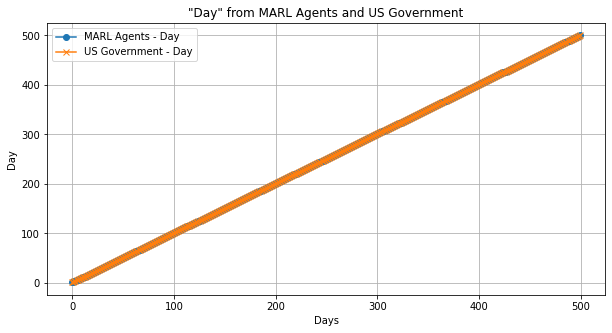

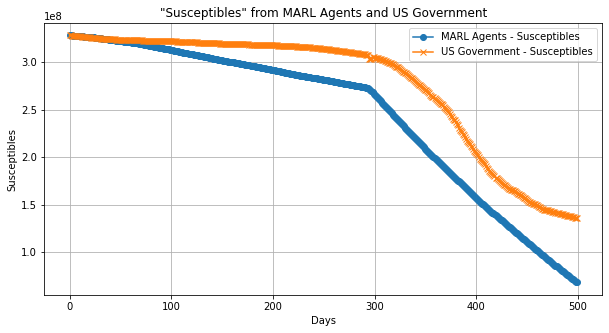

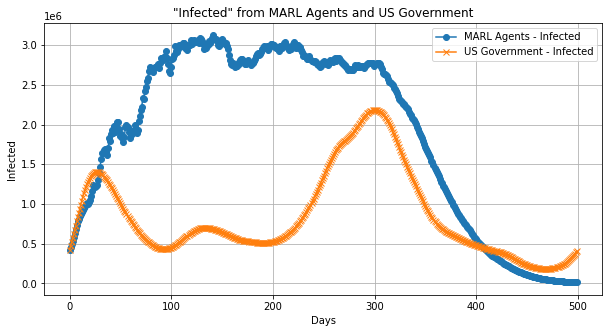

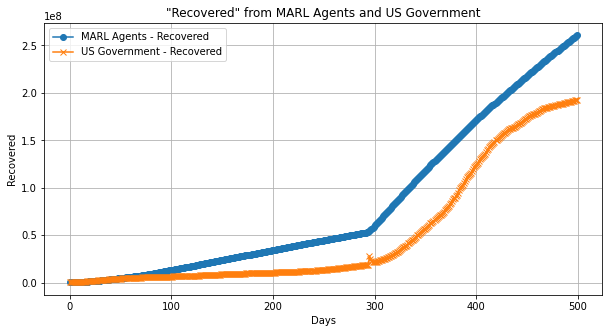

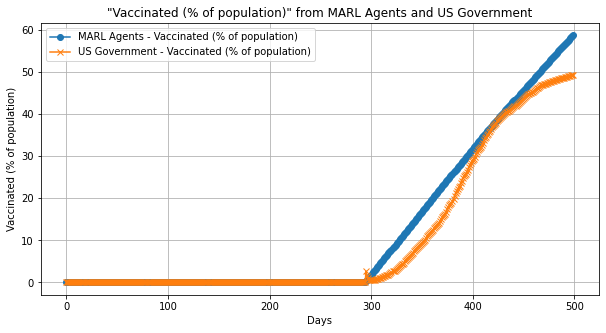

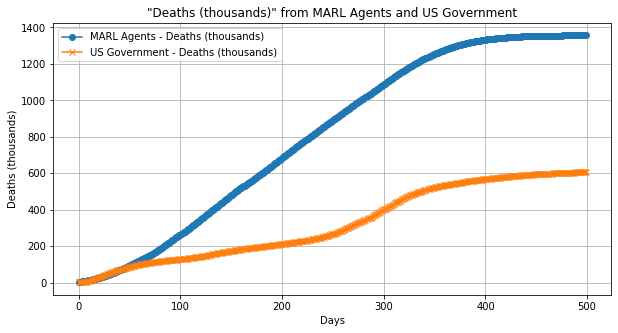

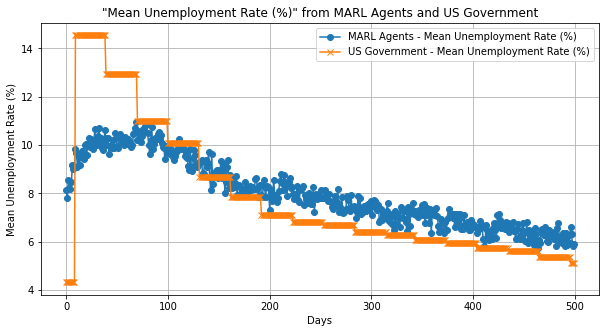

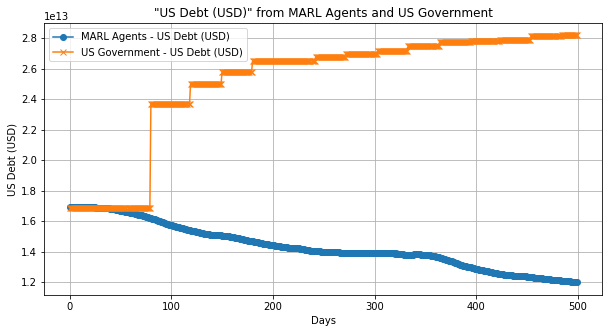

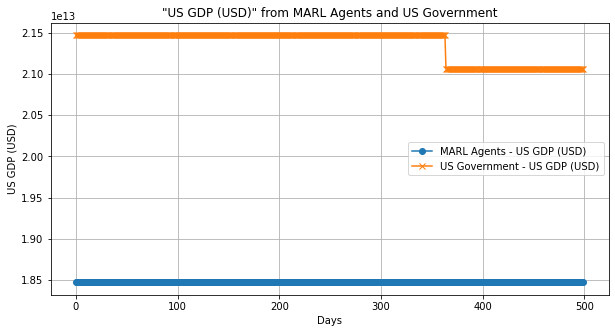

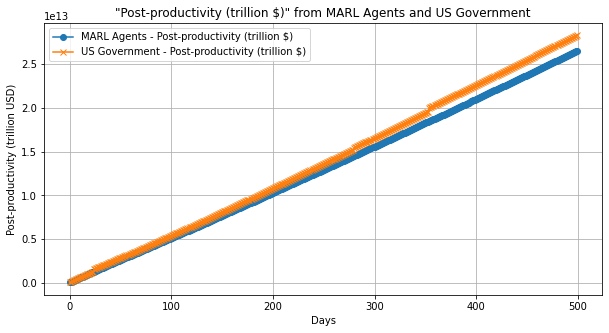

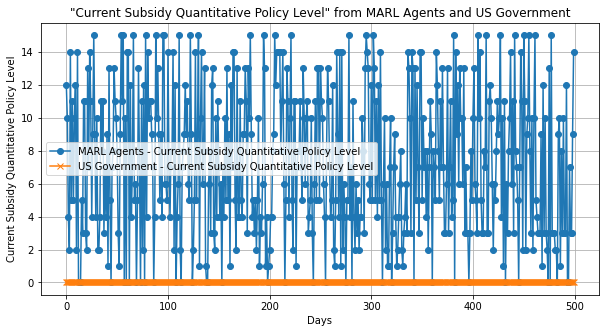

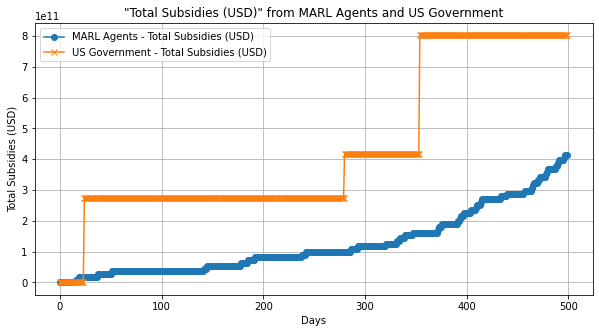

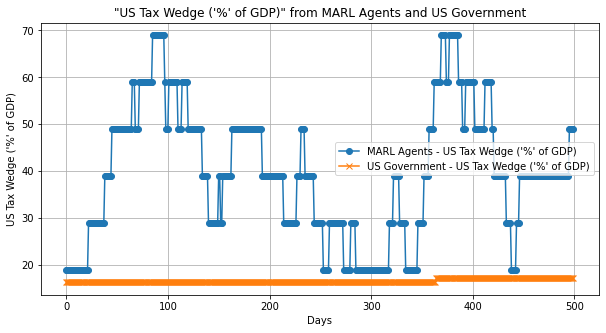

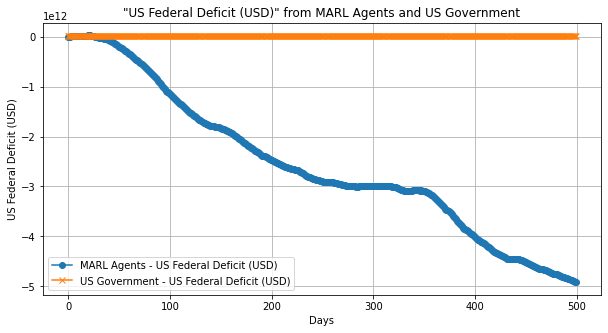

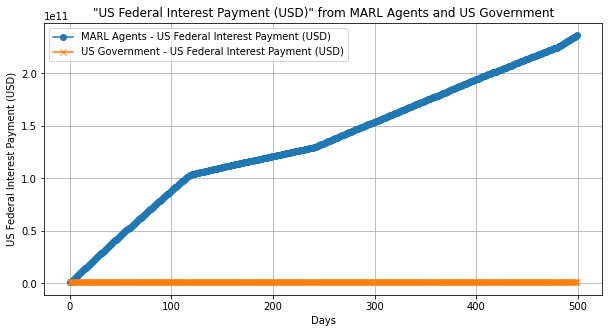

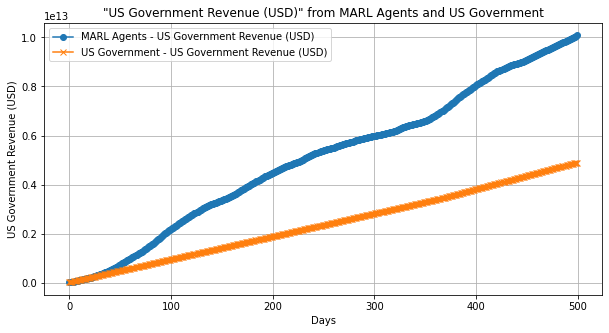

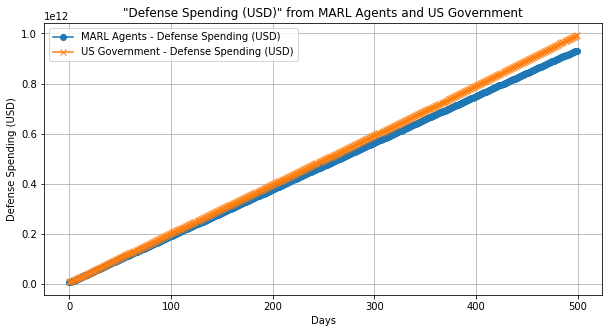

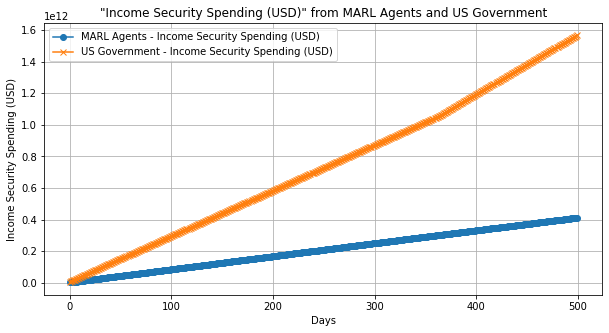

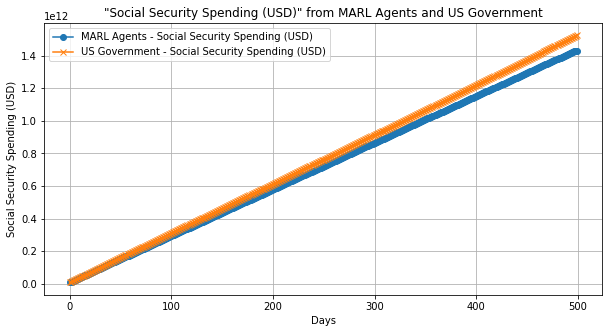

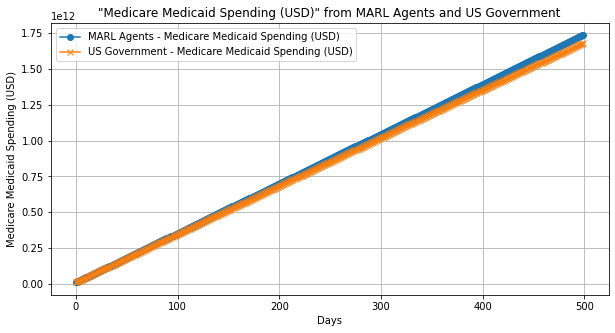

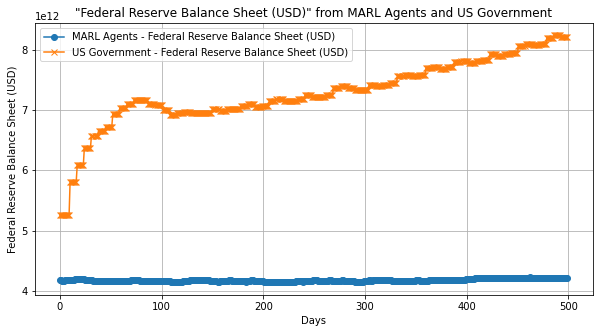

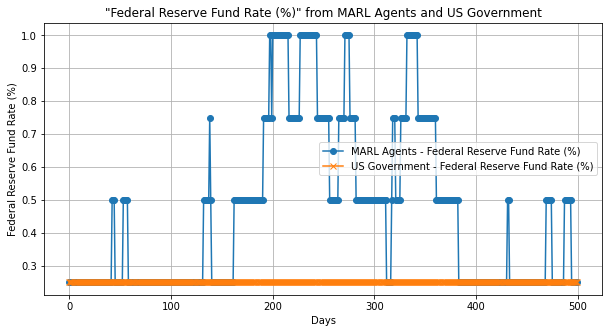

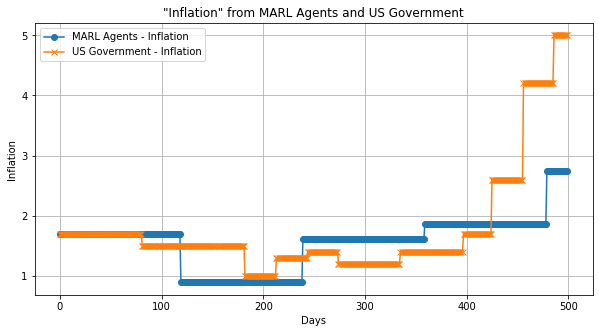

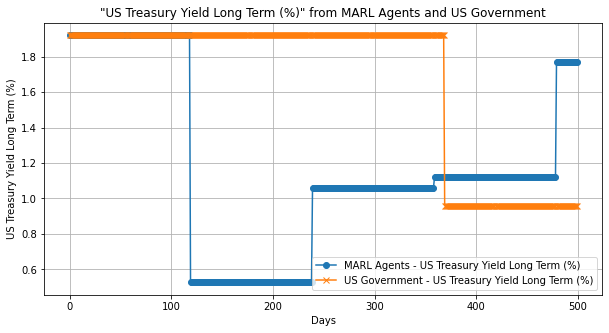

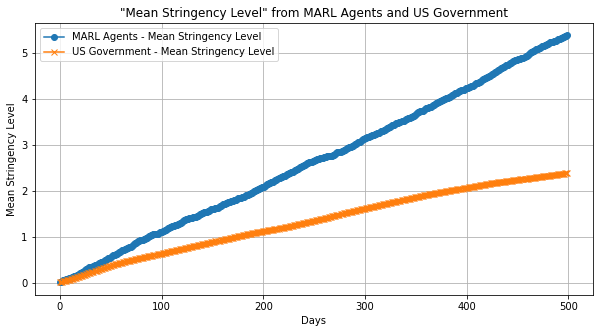

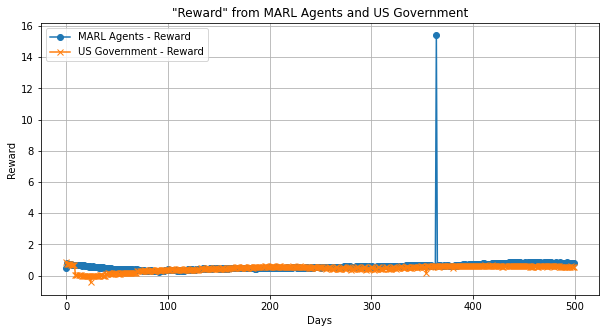

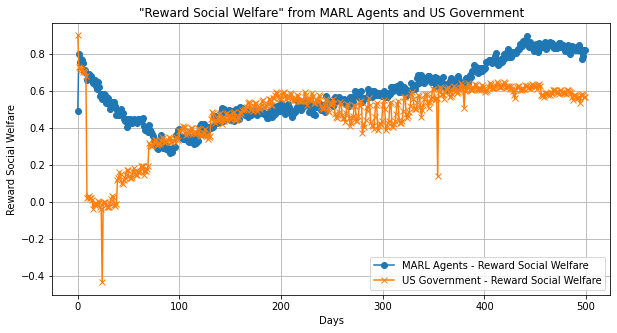

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import os

def compare_csv(file1, file2, label1, label2, output_folder = 'output_folder'):
    # Read the CSV files
    df1 = pd.read_csv(file1)
    df2 = pd.read_csv(file2)
    
    # Ensure the same columns in both DataFrames
    if list(df1.columns) != list(df2.columns):
        raise ValueError("Columns do not match between the two CSV files.")
    
    # Truncate df2 to match the length of df1
    max_length = len(df1) if len(df1) <= len(df2) else len(df2)
    df2 = df2.iloc[:max_length]
    
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    
    # Create plots for each column
    for column in df1.columns:
        name = column
        if '%' in column and 'Fund Rate' not in column:
            df1[column] = df1[column] * 100
            df2[column] = df2[column] * 100
        if 'Inflation' in column:
            df1[column] = df1[column] * 100
            df2[column] = df2[column] * 100
        # if 'USD' in column:
        #     name = name.replace('(USD)', '(trillion USD)')
        if '$' in column:
            name = name.replace('$', 'USD')
        plt.figure(figsize=(10, 5))
        plt.plot(df1[column], label=f'{label1} - {column}', marker='o')
        plt.plot(df2[column], label=f'{label2} - {column}', marker='x')
        plt.title(f'"{column}" from {label1} and {label2}')

        

        plt.xlabel('Days')
        plt.ylabel(name)
        plt.legend()
        plt.grid(True)
        
        # Save the plot to the specified folder
        plt.savefig(f'{output_folder}/{column}_comparison.png')
        plt.show()

# Example usage
import os
ai_csv = os.getcwd() + '/simulation_results-AI-1.00_day.csv'
LabelAI = 'MARL Agents'
real_csv = os.getcwd() + '/simulation_results-real_data_day.csv'
LabelReal = 'US Government'
compare_csv(ai_csv, real_csv, LabelAI, LabelReal)


### Colab

Try this notebook on [Colab](http://colab.research.google.com/github/salesforce/ai-economist/blob/master/tutorials/multi_agent_training_with_rllib.ipynb).

### Prerequisites
It is helpful to be familiar with **Foundation**, a multi-agent economic simulator built for the AI Economist ([paper here](https://arxiv.org/abs/2004.13332)). If you haven't worked with Foundation before, we highly recommend taking a look at our other tutorials:

- [Foundation: the Basics](https://github.com/salesforce/ai-economist/blob/master/tutorials/economic_simulation_basic.ipynb)
- [Extending Foundation](https://github.com/salesforce/ai-economist/blob/master/tutorials/economic_simulation_advanced.ipynb)
- [Optimal Taxation Theory and Simulation](https://github.com/salesforce/ai-economist/blob/master/tutorials/optimal_taxation_theory_and_simulation.ipynb)

## Introduction

Welcome! This tutorial is the first of a series on doing distributed multi-agent reinforcement learning (MARL). Here, we specifically demonstrate how to integrate our multi-agent economic simulation, [Foundation](https://github.com/salesforce/ai-economist/tree/master/ai_economist/foundation), with [RLlib](https://github.com/ray-project/ray/tree/master/rllib), an open-source library for reinforcement learning. We chose to use RLlib, as it provides an easy-to-use and flexible library for MARL. A detailed documentation on RLlib is available [here](https://docs.ray.io/en/master/rllib.html).

We put together these tutorial notebook with the following key goals in mind:
- Provide an exposition to MARL. While there are many libraries and references out there for single-agent RL training, MARL training is not discussed as much, and there aren't many multi-agent rl libraries.
- Provide reference starting code to perform MARL training so the AI Economist community can focus more on building meaningful extensions to Foundation and better-performant algorithms.

We will cover the following concepts in this tutorial:
1. Adding an *environment wrapper* to make the economic simulation compatible with RLlib.
2. Creating a *trainer* object that holds the (multi-agent) policies for environment interaction.
3. Training all the agents in the economic simulation.
4. Generate a rollout using the trainer object and visualize it.

### Dependencies:
You can install the ai-economist package using 
- the pip package manager OR
- by cloning the ai-economist package and installing the requirements (we shall use this when running on Colab):

In [1]:
import os, signal, sys, time
# IN_COLAB = 'google.colab' in sys.modules
#
# if IN_COLAB:
#     !git clone https://github.com/matyascorvinus/ai-economist
#
#     %cd ai-economist
#     !pip install -e .
#
#     # Restart the Python runtime to automatically use the installed packages
#     print("\n\nRestarting the Python runtime! Please (re-)run the cells below.")
#     time.sleep(1)
#     #os.kill(os.getpid(), signal.SIGKILL)
# else:
#     ! pip install ai-economist
# pwd : '/home/supremusdominus/Download/ai-economist/tutorials'
# %cd /home/supremusdominus/Download/ai-economist

# ! pip install -e .

INITIALIZE = True
if INITIALIZE:
    %cd /home/supremusdominus/Download/ai-economist-fed
    !pip install --upgrade pip
    !pip install -e . 
    !pip install scikit-learn

/home/supremusdominus/Download/ai-economist-fed
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 9.8 MB/s eta 0:00:00:00:010:01
  Attempting uninstall: pip
    Found existing installation: pip 23.3.1
    Uninstalling pip-23.3.1:
      Successfully uninstalled pip-23.3.1
Obtaining file:///home/supremusdominus/Download/ai-economist-fed
  Preparing metadata (setup.py) ... done
  Attempting uninstall: ai-economist
    Found existing installation: ai-economist 1.7.1
    Uninstalling ai-economist-1.7.1:
      Successfully uninstalled ai-economist-1.7.1
  Running setup.py develop for ai-economist

[notice] A new release of pip is available: 23.3.1 -> 23.3.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.3.1 -> 23.3.2
[notice] To update, run: pip install --upgrade pip


Install OpenAI Gym to help define the environment's observation and action spaces for use with RLlib.

Install the `RLlib` reinforcement learning library:
- First, install TensorFlow
- Then, install ray[rllib]

Note: RLlib natively supports TensorFlow (including TensorFlow Eager) as well as PyTorch, but most of its internals are framework agnostic. Here's a relevant [blogpost](https://medium.com/distributed-computing-with-ray/lessons-from-implementing-12-deep-rl-algorithms-in-tf-and-pytorch-1b412009297d) that compares running RLlib algorithms with TF and PyTorch. Overall, TF seems to run a bit faster than PyTorch, in our experience, and we will use that in this notebook.

In [4]:
# # We install these specific versions of tensorflow and rllib, that we used in our work.
!pip install gym==0.21
!pip install tensorflow==1.14
!pip install "ray[rllib]==0.8.4"
!pip install opencv-python
!pip install opencv-python-headless==4.1.2.30

In [3]:

# !pip install https://storage.googleapis.com/tensorflow/mac/cpu/tensorflow-1.14.0-py3-none-any.whl 

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.8/105.8 MB 5.5 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 17.7 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 488.5/488.5 kB 14.8 MB/s eta 0:00:00
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.13.0
    Uninstalling tensorflow-estimator-2.13.0:
      Successfully uninstalled tensorflow-estimator-2.13.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.13.0
    Uninstalling tensorboard-2.13.0:
      Successfully uninstalled tensorboard-2.13.0
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.13.1
    Uninstalling tensorflow-2.13.1:
      Successfully uninstalled tensorflow-2.13.1


In [4]:
# Change directory to the tutorials folder
import os, sys
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    os.chdir("/content/ai-economist/tutorials")
else:
    os.chdir(os.path.dirname(os.path.abspath("__file__"))
)

## 1. Adding an Environment Wrapper 

We first define a configuration (introduced in [the basics tutorial](https://github.com/salesforce/ai-economist/blob/master/tutorials/economic_simulation_basics.ipynb)) for the "gather-trade-build" environment with multiple mobile agents (that move, gather resources, build or trade) and a social planner that sets taxes according to (a scaled variant of) the 2018 US tax schedule.

Like we have seen in earlier [tutorials](https://github.com/salesforce/ai-economist/blob/master/tutorials/economic_simulation_basic.ipynb), using `env = foundation.make_env_instance(**env_config)` creates an environment instance `env` with the specified configuration.

In order to use this environment with RLlib, we will also need to add the environment's `observation_space` and `action_space` attributes. Additionally, the environment itself must subclass the [`MultiAgentEnv`](https://github.com/ray-project/ray/blob/master/rllib/env/multi_agent_env.py) interface, which can return observations and rewards from multiple ready agents per step. To this end, we use an environment [wrapper](https://github.com/salesforce/ai-economist/blob/master/tutorials/rllib/env_wrapper.py).

Upon applying the wrapper to our environment, we have now defined observation and action spaces for the agents and the planner, indicated with `(a)` and `(p)` respectively. Also, (a useful tip) you can still access the environment instance and its attributes simply by using `env_obj.env`

In summary, the observation spaces are represented as `Box` objects and the action spaces as `Discrete` objects (for more details on these types, see the OpenAI documentation [page](https://gym.openai.com/docs/#spaces)).

Briefly looking at the shapes of the observation features (the numbers in parentheses), you will see that we have some one-dimensional features (e.g. `action-mask`, `flat`, `time`) as well as spatial features (e.g., `world-idx-map`, `world-map`)

A couple of quick notes:
- An `action_mask` is used to mask out the actions that are not allowed by the environment. For instance, a mobile agent cannot move beyond the boundary of the world. Hence, in position (0, 0), a mobile cannot move "Left" or "Down", and the corresponding actions in the mask would be nulled out. Now, the RL agent can still recommend to move "Left" or "Down", but the action isn't really taken.
- The key `flat` arises since we set `flatten_observations': True`. Accordingly, the scalar and vector raw observations are all concatenated into this single key. If you're curious to see the entire set of raw observations, do set `flatten_observations': False` in the env_config, and re-run the above cell.

Looking at the action spaces, the mobile agents can take 50 possible actions (including 1 NO-OP action or do nothing (always indexed 0), 44 trading-related actions, 4 move actions along the four directions and 1 build action)

The planner sets the tax rates for 7 brackets, each from 0-100% in steps of 5%, so that's 21 values. Adding the NO-OP action brings the planner action space to `MultiDiscrete([22 22 22 22 22 22 22])`.

## 2. Creating a *Trainer* Object

In order to train our economic simulation environment with RLlib, you will need familiarity with one of the key classes: the [`Trainer`](https://docs.ray.io/en/master/rllib-training.html). The trainer object maintains the relationships that connect each agent in the environment to its corresponding trainable policy, and essentially helps in training, checkpointing policies and inferring actions. It helps to co-ordinate the workflow of collecting rollouts and optimizing the various policies via a reinforcement learning algorithm. Inherently, RLlib maintains a wide suite of [algorithms](https://docs.ray.io/en/master/rllib-algorithms.html) for multi-agent learning (which was another strong reason for us to consider using RLlib) - available options include SAC, PPO, PG, A2C, A3C, IMPALA, ES, DDPG, DQN, MARWIL, APEX, and APEX_DDPG. For the remainder of this tutorial, we will stick to using [Proximal Policy Optimization](https://openai.com/blog/openai-baselines-ppo/) (PPO), an algorithm known to perform well generally.

Every algorithm has a corresponding trainer object; in the context of PPO, we invoke the `PPOTrainer` object.

In [ ]:
env_config_dict = {
    # Scenario name - determines which scenario class to use
    "scenario_name": "CovidAndEconomySimulation",

    # The list of components in this simulation
    "components": [
        {"ControlUSStateOpenCloseStatus": {
            # action cooldown period in days.
            # Once a stringency level is set, the state(s) cannot switch to another level
            # for a certain number of days (referred to as the "action_cooldown_period")
            "action_cooldown_period": 28
        }},
        {"FederalGovernmentSubsidyAndQuantitativePolicies": {
            # The number of subsidy levels.
            "num_subsidy_quantitative_policy_level": 141,
            # The number of days over which the total subsidy amount is evenly rolled out.
            "subsidy_quantitative_policy_interval": 90,
            # The maximum annual subsidy that may be allocated per person.
            "max_annual_monetary_unit_per_person": 20000,
        }},
        {"VaccinationCampaign": {
            # The number of vaccines available per million people everyday.
            "daily_vaccines_per_million_people": 3000,
            # The number of days between vaccine deliveries.
            "delivery_interval": 1,
            # The date (YYYY-MM-DD) when vaccination begins
            "vaccine_delivery_start_date": "2021-01-12",
        }},
    ],

    # Date (YYYY-MM-DD) to start the simulation.
    "start_date": "2020-03-22",
    # How long to run the simulation for (in days)
    "episode_length": 405,

    # use_real_world_data (bool): Replay what happened in the real world.
    # Real-world data comprises SIR (susceptible/infected/recovered),
    # unemployment, government policy, and vaccination numbers.
    # This setting also sets use_real_world_policies=True.
    "use_real_world_data": False,
    # use_real_world_policies (bool): Run the environment with real-world policies
    # (stringency levels and subsidies). With this setting and
    # use_real_world_data=False, SIR and economy dynamics are still
    # driven by fitted models.
    "use_real_world_policies": False,

    # A factor indicating how much more the
    # states prioritize health (roughly speaking, loss of lives due to
    # opening up more) over the economy (roughly speaking, a loss in GDP
    # due to shutting down resulting in more unemployment) compared to the
    # real-world.
    # For example, a value of 1 corresponds to the health weight that
    # maximizes social welfare under the real-world policy, while
    # a value of 2 means that states care twice as much about public health
    # (preventing deaths), while a value of 0.5 means that states care twice
    # as much about the economy (preventing GDP drops).
    "health_priority_scaling_agents": 1,
    # Same as above for the planner
    "health_priority_scaling_planner": 1,

    # Full path to the directory containing
    # the data, fitted parameters and model constants. This defaults to
    # "ai_economist/datasets/covid19_datasets/data_and_fitted_params".
    # For details on obtaining these parameters, please see the notebook
    # "ai-economist-foundation/ai_economist/datasets/covid19_datasets/
    # gather_real_world_data_and_fit_parameters.ipynb".
    "path_to_data_and_fitted_params": "",

    # Economy-related parameters
    # Fraction of people infected with COVID-19. Infected people don't work.
    "infection_too_sick_to_work_rate": 0.1,
    # Fraction of the population between ages 18-65.
    # This is the subset of the population whose employment/unemployment affects
    # economic productivity.
    "pop_between_age_18_65": 0.6,
    # Percentage of interest paid by the federal
    # government to borrow money from the federal reserve for COVID-19 relief
    # (direct payments). Higher interest rates mean that direct payments
    # have a larger cost on the federal government's economic index.
    "risk_free_interest_rate": 0.03,
    # CRRA eta parameter for modeling the economic reward non-linearity.
    "economic_reward_crra_eta": 2,

    # Number of agents in the simulation (50 US states + Washington DC)
    "n_agents": 51,
    # World size: Not relevant to this simulation, but needs to be set for Foundation
    "world_size": [1, 1],
    # Flag to collate all the agents' observations, rewards and done flags into a single matrix
    "collate_agent_step_and_reset_data": False,
}
from rllib.env_wrapper import RLlibEnvWrapper
env_obj = RLlibEnvWrapper({"env_config_dict": env_config_dict})
import ray
from ray.rllib.agents.ppo import PPOTrainer
policies = {
    "a": (
        None,  # uses default policy
        env_obj.observation_space,
        env_obj.action_space,
        {}  # define a custom agent policy configuration.
    ),
    "p": (
        None,  # uses default policy
        env_obj.observation_space_pl,
        env_obj.action_space_pl,
        {}  # define a custom planner policy configuration.
    )
}

# In foundation, all the agents have integer ids and the social planner has an id of "p"
policy_mapping_fun = lambda i: "a" if str(i).isdigit() else "p"

policies_to_train = ["a", "p"]

trainer_config = {
    "multiagent": {
        "policies": policies,
        "policies_to_train": policies_to_train,
        "policy_mapping_fn": policy_mapping_fun,
    },
    "num_gpus": 1
}

trainer_config.update(
    {
        "num_workers": 0,
        "num_envs_per_worker": 1,
        # Other training parameters
        # "train_batch_size":  10,
        # "sgd_minibatch_size": 5,
        # "num_sgd_iter": 1
    }
)

# We also add the "num_envs_per_worker" parameter for the env. wrapper to index the environments.
env_config = {
    "env_config_dict": env_config_dict,
    "num_envs_per_worker": trainer_config.get('num_envs_per_worker'),
}

trainer_config.update(
    {
        "env_config": env_config
    }
)

# Initialize Ray
ray.init(webui_host="127.0.0.1")
# Create the PPO trainer.
trainer = PPOTrainer(
    env=RLlibEnvWrapper,
    config=trainer_config,
)

# Number of US states: 51
# self.us_gdp_2019:  21466585914800.0
# self.us_federal_deficit:  2465753424.6575336
# self.us_government_revenue:  9589041095.890411
# self.us_government_mandatory_and_discretionary_spending:  12054794520.547945
NUM_ITERS = 1000  
for iteration in range(NUM_ITERS):
    print(f'********** Iter : {iteration} **********')
    result = trainer.train()
    checkpoint_path = trainer.save()
    print("Model checkpoint saved at:", checkpoint_path)
    print(f'''episode_reward_mean: {result.get('episode_reward_mean')}''')

PPOTrainer can be instantiated with 
- `env`: an environment creator (i.e, RLlibEnvWrapper() in our case)
- `config`: algorithm-specific configuration data for setting the various components of the RL training loop including the environment, rollout worker processes, training resources, degree of parallelism, framework used, and the policy exploration strategies.

Note: There are several configuration settings related to policy architectures, rollout collection, minibatching, and other important hyperparameters, that need to be set carefully in order to train effectively. For the sake of the high-level exposition, we allow RLlib to use most of the the default settings. Check out the list of default [common configuration parameters](https://docs.ray.io/en/releases-0.8.4/rllib-training.html#common-parameters) and default [PPO-specific configuration parameters](https://docs.ray.io/en/releases-0.8.4/rllib-algorithms.html?highlight=PPO#proximal-policy-optimization-ppo). Custom environment configurations may be passed to environment creator via `config["env_config"]`.

RLlib also chooses default built-in [models](https://docs.ray.io/en/releases-0.8.4/rllib-models.html#built-in-models-and-preprocessors) for processing the observations. The models are picked based on a simple heuristic: a [vision](https://github.com/ray-project/ray/blob/master/rllib/models/tf/visionnet.py) network for observations that have shape of length larger than 2 (for example, (84 x 84 x 3)), and a [fully connected](https://github.com/ray-project/ray/blob/master/rllib/models/tf/fcnet.py) network for everything else. Custom models can be configured via the `config["policy"]["model"]` key.

In the context of multi-agent training, we will also need to set the multi-agent configuration:
```python
"multiagent": {
        # Map of type MultiAgentPolicyConfigDict from policy ids to tuples
        # of (policy_cls, obs_space, act_space, config). This defines the
        # observation and action spaces of the policies and any extra config.
        "policies": {},
        # Function mapping agent ids to policy ids.
        "policy_mapping_fn": None,
        # Optional list of policies to train, or None for all policies.
        "policies_to_train": None,
    },
```

To this end, let's notate the agent policy id by `"a"` and the planner policy id by `"p"`. We can set `policies`, `policy_mapping_fun` and `policies_to_train` as follows.

Create a multiagent trainer config holding the trainable policies and their mappings.

With distributed RL, architectures typically comprise several **roll-out** and **trainer** workers operating in tandem
![](assets/distributed_rl_architecture.png)

The roll-out workers repeatedly step through the environment to generate and collect roll-outs in parallel, using the actions sampled from the policy models on the roll-out workers or provided by the trainer worker.
Roll-out workers typically use CPU machines, and sometimes, GPU machines for richer environments.
Trainer workers gather the roll-out data (asynchronously) from the roll-out workers and optimize policies on CPU or GPU machines.

In this context, we can also add a `num_workers` configuration parameter to specify the number of rollout workers, i.e, those responsible for gathering rollouts. Note: setting `num_workers=0` will mean the rollouts will be collected by the trainer worker itself. Also, each worker can collect rollouts from multiple environments in parallel, which is specified in `num_envs_per_worker`; there will be a total of `num_workers` $\times$ `num_envs_per_worker` environment replicas used to gather rollouts.
Note: below, we also update some of the default trainer settings to keep the iteration time small.

Finally, we need to add the environment configuration to the trainer configuration.

One the training configuration is set, we will need to initialize ray and create the PPOTrainer object.

## 3. Perform Training

And that's it! We are now ready to perform training by invoking `trainer.train()`; we call it for just a few number of iterations.

In [ ]:
NUM_ITERS = 100 
for iteration in range(NUM_ITERS):
    print(f'********** Iter : {iteration} **********')
    result = trainer.train()
    print(f'''episode_reward_mean: {result.get('episode_reward_mean')}''')

By default, the results will be logged to a subdirectory of `~/ray_results`. This subdirectory will contain a file `params.json` which contains the hyperparameters, a file `result.json` which contains a training summary for each episode and a TensorBoard file that can be used to visualize training process with TensorBoard by running|
```shell
tensorboard --logdir ~/ray_results
```

## 4. Generate and Visualize the Environment's Dense Logs

At any point during training, we would also want to inspect the environment's dense logs in order to deep-dive into the training results. Introduced in our [basic tutorial](https://github.com/salesforce/ai-economist/blob/master/tutorials/economic_simulation_basic.ipynb#Visualize-using-dense-logging), dense logs are basically logs of each agent's states, actions and rewards at every point in time, along with a snapshot of the world state.

There are two equivalent ways to fetch the environment's dense logs using the trainer object.

a. Simply retrieve the dense log from the workers' environment objects

b. Generate dense log(s) from the most recent trainer policy model weights

### 4a. Simply retrieve the dense log from the workers' environment objects

From each rollout worker, it's straightforward to retrieve the dense logs using some of the function attributes.

In [ ]:
# Below, we fetch the dense logs for each rollout worker and environment within

dense_logs = {}
# Note: worker 0 is reserved for the trainer actor
for worker in range((trainer_config["num_workers"] > 0), trainer_config["num_workers"] + 1):
    for env_id in range(trainer_config["num_envs_per_worker"]):
        dense_logs["worker={};env_id={}".format(worker, env_id)] = \
        trainer.workers.foreach_worker(lambda w: w.async_env)[worker].envs[env_id].env.previous_episode_dense_log

In [ ]:
# We should have num_workers x num_envs_per_worker number of dense logs
print(dense_logs.keys())

### 4b. Generate a dense log from the most recent trainer policy model weights

We may also use the trainer object directly to play out an episode. The advantage of this approach is that we can re-sample the policy model any number of times and generate several rollouts.

In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from IPython import display
from utils import plotting  # plotting utilities for visualizing env. state

def do_plot(env, ax, fig):
    """Plots world state during episode sampling."""
    maps = env.env.world.maps
    locs = [agent.loc for agent in env.env.world.agents] 

    cmap_order = None
    plotting.plot_map(maps, locs, ax, cmap_order)
    ax.set_aspect('equal')
    display.display(fig)
    display.clear_output(wait=True)

def generate_rollout_from_current_trainer_policy(
    trainer, 
    env_obj,
    num_dense_logs=1
):
    dense_logs = {}
    for idx in range(num_dense_logs):
        # Set initial states
        agent_states = {}
        for agent_idx in range(env_obj.env.n_agents):
            agent_states[str(agent_idx)] = trainer.get_policy("a").get_initial_state()
        planner_states = trainer.get_policy("p").get_initial_state()   

        # Play out the episode
        obs = env_obj.reset(force_dense_logging=True)
        fig, ax = plt.subplots(1, 1, figsize=(10, 10))
        for t in range(env_obj.env.episode_length):
            actions = {}
            for agent_idx in range(env_obj.env.n_agents):
                # Use the trainer object directly to sample actions for each agent
                actions[str(agent_idx)] = trainer.compute_action(
                    obs[str(agent_idx)], 
                    agent_states[str(agent_idx)], 
                    policy_id="a",
                    full_fetch=False
                )

            # Action sampling for the planner
            actions["p"] = trainer.compute_action(
                obs['p'], 
                planner_states, 
                policy_id='p',
                full_fetch=False
            )

            obs, rew, done, info = env_obj.step(actions)        
            if ((t+1) % 100) == 0:
                do_plot(env_obj, ax, fig)
            if done['__all__']:
                break
        dense_logs[idx] = env_obj.env.dense_log
    return dense_logs

Inside covid19_components.py: 0 GPUs are available.
No GPUs found! Running the simulation on a CPU.
Inside covid19_env.py: 0 GPUs are available.
No GPUs found! Running the simulation on a CPU.


In [ ]:
dense_logs = generate_rollout_from_current_trainer_policy(
    trainer, 
    env_obj,
    num_dense_logs=100
)

### Visualizing the episode dense logs

Once we obtain the dense logs, we can use the plotting utilities we have created to examine the episode dense logs and visualize the the world state, agent-wise quantities, movement, and trading events.

In [ ]:
from utils import plotting  # plotting utilities for visualizing env. state

dense_log_idx = 0
for index, element in enumerate(dense_logs):
  print('Plot ', index)
  plotting.breakdown(dense_logs[index]);

In [ ]:
# Shutdown Ray after use
ray.shutdown()

And that's it for now. See you in the [next](https://github.com/salesforce/ai-economist/blob/master/tutorials/two_level_curriculum_learning_with_rllib.md) tutorial :)